In [ ]:
# Face Mask Detection using MobileNet & OpenCV
# reference: https://www.kaggle.com/taha07/face-mask-detection-using-opencv-mobilenet/notebook

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import cv2
import random
import tensorflow as tf

In [2]:
import os
os.listdir('./Face Mask Dataset/Train/')

['WithMask', 'WithoutMask']

In [3]:
print("Images in Train Dataset:\n")
print("Number of Images for with Mask category:{}".format(len(os.listdir('./Face Mask Dataset/Train/WithMask'))))
print("Number of Images for with WithoutMask category:{}".format(len(os.listdir('./Face Mask Dataset/Train/WithoutMask'))))

Images in Train Dataset:

Number of Images for with Mask category:5000
Number of Images for with WithoutMask category:5000


In [4]:
train_dir = './Face Mask Dataset/Train/'
test_dir = './Face Mask Dataset/Test/'

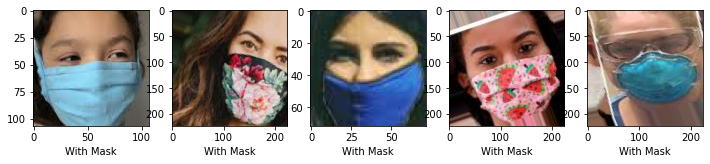

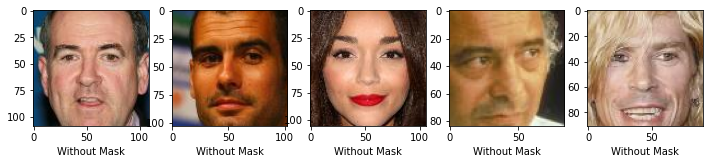

In [5]:
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithoutMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [6]:
height = 150
width=150
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [83]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(input_shape=(150,150,3), weights = 'imagenet',include_top = False)


c:\users\zlq43\anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [84]:
for layer in mobilenet.layers:
    layer.trainable = False

In [85]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [87]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [88]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [93]:
import time
start = time.time()
history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,validation_data=valid,
                             validation_steps = len(valid)//32,
#                               callbacks=[checkpoint,earlystop],
                              epochs=15)
end = time.time()
print("training time:", end-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 1 steps
Epoch 1/15
7/7 [==============================] - 1s 178ms/step - loss: 0.1432 - accuracy: 0.9375 - val_loss: 0.8511 - val_accuracy: 0.8750
Epoch 2/15
7/7 [==============================] - 1s 196ms/step - loss: 0.1914 - accuracy: 0.9777 - val_loss: 0.9605 - val_accuracy: 0.8125
Epoch 3/15
7/7 [==============================] - 1s 194ms/step - loss: 0.2010 - accuracy: 0.9598 - val_loss: 1.8760 - val_accuracy: 0.8750
Epoch 4/15
7/7 [==============================] - 1s 198ms/step - loss: 0.1437 - accuracy: 0.9688 - val_loss: 2.3970 - val_accuracy: 0.7812
Epoch 5/15
7/7 [==============================] - 1s 193ms/step - loss: 0.1429 - accuracy: 0.9598 - val_loss: 2.2530 - val_accuracy: 0.8438
Epoch 6/15
7/7 [==============================] - 1s 192ms/step - loss: 0.0455 - accuracy: 0.9732 - val_loss: 2.3578 - val_accuracy: 0.8125
Epoch 7/15
7/7 [==============================] - 1s 195ms/step - loss

In [94]:
model.evaluate_generator(valid)

  ...
    to  
  ['...']


[1.2163129347036519, 0.8705]

In [ ]:
model.save("face_mask.h5")

In [7]:
from pathlib import Path

In [8]:
Path.cwd()

WindowsPath('D:/zhao/face_mask_detection')

In [9]:
from tensorflow.keras.models import load_model
mask_model = load_model('face_mask.h5')
print("model loaded")

model loaded


In [33]:
import time
start = time.time()
i = Path.cwd() / "withmask_easy_case.png"
frame = cv2.imread(str(i))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

Mask
0.05671119689941406


In [34]:
start = time.time()
j = Path.cwd() / "withmask_good_case.png"
frame = cv2.imread(str(j))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

Mask
0.04068493843078613


In [35]:
start = time.time()
k = Path.cwd() / "withmask_challenging_case.png"
frame = cv2.imread(str(k))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

No Mask
0.04004931449890137


In [36]:
start = time.time()
a = Path.cwd() / "withoutmask_easy.png"
frame = cv2.imread(str(a))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

No Mask
0.0426480770111084


In [37]:
start = time.time()
b = Path.cwd() / "withoutmask_good.png"
frame = cv2.imread(str(b))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

No Mask
0.04362750053405762


In [38]:
start = time.time()
c = Path.cwd() / "withoutmask_hard.png"
frame = cv2.imread(str(c))
resize_img  = cv2.resize(frame,(150,150))
normalized = resize_img/255.0
reshape = np.reshape(normalized,(1,150,150,3))
reshape = np.vstack([reshape])
prediction = mask_model.predict_classes(reshape)
label = "Mask"
if prediction[0] == 1:
    label = "No Mask"
print(label)
end = time.time()
print(end-start)

Mask
0.04041337966918945


In [39]:
import os, time
start = time.time()
count1 = 0
mask = 0
for dirname, _, filenames in os.walk('Face Mask Dataset/Test/WithMask'):
    for filename in filenames:
        count1 = count1 + 1
        i = os.path.join(dirname, filename)
        frame = cv2.imread(str(i))
        resize_img  = cv2.resize(frame,(150,150))
        normalized = resize_img/255.0
        reshape = np.reshape(normalized,(1,150,150,3))
        reshape = np.vstack([reshape])
        prediction = mask_model.predict_classes(reshape)
        if prediction == 0:
            mask = mask + 1
True_Positive = mask 
False_Negative = count1 - mask
end = time.time()
print("prediction time: ", end-start)
print("True_Positive: ", True_Positive)
print("False_Negative: ", False_Negative)
print(count1)

prediction time:  16.3819682598114
True_Positive:  401
False_Negative:  82
483


In [40]:
import os, time
start = time.time()
count2 = 0
no_mask = 0
for dirname, _, filenames in os.walk('Face Mask Dataset/Test/WithoutMask'):
    for filename in filenames:
        count2 = count2 + 1
        i = os.path.join(dirname, filename)
        frame = cv2.imread(str(i))
        resize_img  = cv2.resize(frame,(150,150))
        normalized = resize_img/255.0
        reshape = np.reshape(normalized,(1,150,150,3))
        reshape = np.vstack([reshape])
        prediction = mask_model.predict_classes(reshape)
        if prediction == 1:
            no_mask = no_mask + 1
True_Negative  = no_mask
False_Positive = count2-no_mask
end = time.time()
print("prediction time: ", end-start)
print("True_Negative: ",True_Negative)
print("False_Positive: ",False_Positive)
print(count2)

prediction time:  17.214407205581665
True_Negative:  499
False_Positive:  10
509


In [41]:
count = count1 + count2
accuracy = (mask + no_mask) / count
print(accuracy)

0.907258064516129
